<a href="https://colab.research.google.com/github/Rogerio-mack/IA/blob/main/AI_particle_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[ref](https://classroom.udacity.com/courses/cs373/lessons/48704330/concepts/484805920923)

Refs

Particles 

https://towardsdatascience.com/particle-filter-on-localisation-9e0802282aaf

Kalman Filter

1D Discrete
https://towardsdatascience.com/kalman-filter-1-the-basics-68f89deb2613

2D Discrete
https://towardsdatascience.com/kalman-filter-2-grid-world-localisation-93674dc750c6

2D Continous (Kalman)
https://towardsdatascience.com/kalman-filter-3-localisation-in-continuous-state-space-1c979f6bde5b

Particles

https://salzi.blog/2015/05/25/particle-filters-with-python/

https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/


In [1]:
from math import *
import random
import numpy as np

In [2]:
landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0


class robot:
    def __init__(self):
        self.x = random.random() * world_size  # initialise with random
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * pi
        
        self.forward_noise = 0.0
        self.turn_noise    = 0.0
        self.sense_noise   = 0.0
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
    
    
    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    
    def sense(self):
        Z = []
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z
    
    
    def move(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (cos(orientation) * dist)
        y = self.y + (sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size
        
        # set particle
        res = robot()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
    
    
    def Gaussian(self, mu, sigma, x):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))
    
    
    def measurement_prob(self, measurement):
        # calculates how likely a measurement should be
        prob = 1.0
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob
    
    
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))



def eval(r, p):
    s = 0.0;
    for i in range(len(p)): # calculate mean error
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = sqrt(dx * dx + dy * dy)
        s += err
    return s / float(len(p))

In [3]:
forward_noise = 5.0 
turn_noise = 0.1
sense_noise = 5.0  # noise variance

myrobot = robot()

myrobot.set_noise(forward_noise, turn_noise, sense_noise)
myrobot.set(30., 50., pi/2)
myrobot = myrobot.move(-pi/2, 15.)

print(myrobot.sense())

myrobot = myrobot.move(-pi/2, 10.)

print(myrobot.sense())

[43.475110086003156, 46.74708324909791, 48.04052996520099, 39.52016970747568]
[41.59472338070426, 51.67213511760123, 39.919705298979856, 37.06030133191057]


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

In [5]:
landmarks[:]

[[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]

In [6]:
np.array(landmarks)[:,0]

array([20., 80., 20., 80.])

In [7]:
np.array(landmarks)[:,1]

array([20., 80., 80., 20.])

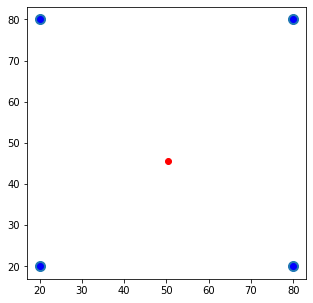

In [8]:
# import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))

plt.plot(myrobot.x,myrobot.y,'ro')
for pos in landmarks:
  plt.plot(pos[0],pos[1],'bo')

plt.scatter(np.array(landmarks)[:,0],np.array(landmarks)[:,1],s=100)  

plt.show()

## Particles
---
Initialise random robots in the world

### Particle Filter Steps
---
1. measure the probability of each particle
2. resample based on the probability weight
3. repeatedly move to approach orientation

In [9]:
N = 1000
p = []

for _ in range(N):
    x = robot()
    x.set_noise(0.05, 0.05, 5.0)  # add noise
    p.append(x)

p[:5]

[[x=42.768 y=68.051 orient=2.1694],
 [x=69.752 y=50.985 orient=3.1872],
 [x=81.795 y=57.908 orient=3.9371],
 [x=54.852 y=2.4372 orient=1.2812],
 [x=17.196 y=93.743 orient=0.4774]]

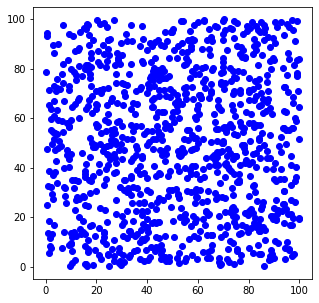

In [10]:
plt.figure(figsize=(5,5))

for robo in p:
  plt.plot(robo.x,robo.y,'bo')
plt.show()

In [11]:
# actual location
myrobot = robot()
myrobot = myrobot.move(0.1, 5.0)
Z = myrobot.sense()
print(myrobot)

[x=73.787 y=24.353 orient=0.7240]


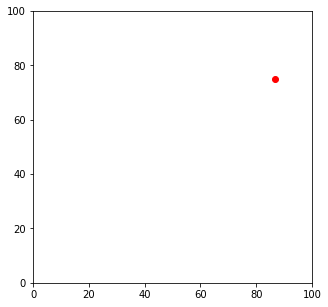

In [12]:
def drawframe(n):

    global p, myrobot, ax
    # fig, ax = plt.subplots(1,1,figsize=(5,5))


    # ax.set_xlim([0,100])
    # ax.set_ylim([0,100])
    
    # for robo in p:
    #   ax.plot(robo.x,robo.y,'bo')
    plt.cla()
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])


    plot = ax.plot(myrobot.x,myrobot.y,'ro')

    # plot = plt.show()
    # '''
    myrobot = myrobot.move(0.1, 5.0)

    return plot

from matplotlib import animation

# fig = plt.figure(figsize=(5,5))

fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.set_xlim([0,100])
ax.set_ylim([0,100])

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=10, interval=100, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())
# plt.close()

# from IPython import display

# video = anim.to_html5_video()
# html = display.HTML(video)
# display.display(html)
# plt.close()

In [13]:
x, y = [], []
for r in p:
  x.append(r.x), y.append(r.y)

xy = np.array([x,y])
xy[0,:]

array([4.27685763e+01, 6.97523671e+01, 8.17953149e+01, 5.48521841e+01,
       1.71968962e+01, 4.61635563e+01, 8.52943582e+01, 4.57260000e+01,
       4.30842906e+01, 9.39539177e+01, 6.40026219e+00, 2.90397004e+01,
       6.75929257e+01, 2.75541905e+00, 7.07641508e+01, 6.30256171e+01,
       8.09125377e+01, 9.45511280e+01, 6.91480766e+00, 4.74310015e+01,
       6.63343258e+01, 3.34214507e+01, 5.93615510e+01, 4.46798854e+01,
       2.46119701e+00, 8.70435216e+01, 1.04286853e+01, 8.87816030e+01,
       7.61678506e+01, 4.48356252e+01, 9.68407365e+01, 5.25862983e+01,
       5.78168252e+01, 9.15747246e+00, 3.95361289e+01, 3.08942194e+01,
       6.24945109e+01, 4.54952119e+01, 6.79575961e+01, 3.49364423e+01,
       7.18359473e+01, 7.82160233e+01, 5.84066647e+01, 8.59950368e+01,
       3.85974934e+01, 1.18663181e+01, 5.57199266e+00, 1.15711867e+01,
       4.69183756e+01, 3.37327730e+01, 4.43480271e+01, 2.69871800e+01,
       6.84910766e+01, 7.72527871e+01, 6.98825582e+01, 1.13130176e+01,
      

In [14]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)
    return particles, weights, indexes

N = 1000
T = 10
n = 10

# initialise randomly guessed particles
p = []
for i in range(N):
    x = robot()
    x.set_noise(0.05, 0.05, 5.0)
    p.append(x)

init_err = eval(myrobot, p)
print("initial err", init_err)

rd = 0
# for rd in range(T):
def drawframe(n):
    
    # '''
    # for a in p:
    #   print(a.x, a.y)
    global landmarks, p, myrobot, ax
    
    plt.cla()
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])

    # for pos in landmarks:
    #   plt.plot(pos[0],pos[1],'ko')
    ax.scatter(np.array(landmarks)[:,0],np.array(landmarks)[:,1],s=200,c='k',marker='+')    

    # for robo in p:
    #  ax.plot(robo.x,robo.y,'bo',alpha=0.3)
    x, y = [], []
    for r in p:
      x.append(r.x), y.append(r.y)

    xy = np.array([x,y])
    ax.scatter(xy[0,:],xy[1,:],alpha=0.3)

    plot = ax.plot(myrobot.x,myrobot.y,'ro')


    if n < 2: return plot

    # plot = plt.show()
    # '''
    myrobot = myrobot.move(0.1, 5.0)
    Z = myrobot.sense()
    
    p2 = []
    for i in range(N):
        # turn 0.1 and move 5 meters
        p2.append(p[i].move(0.1, 5.0))
    p = p2

    # given the particle's location, how likely measure it as Z
    w = []

    for rob in p:
        prob = rob.measurement_prob(Z)  # Z remains the same
        w.append(prob)
    
    ''' Sebastian Khun trick...  
    # resampling particles based on prabability weights
    p3 = []
    index = int(random.random()*N)
    beta = 0
    mw = max(w)

    for i in range(N):
        beta += random.random() * 2 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1)%N
        p3.append(p[index])
    p = p3
    '''
    cumulative_sum = np.cumsum(w)
    # cumulative_sum[-1] = 1. # avoid round-off error
    cumulative_sum =  cumulative_sum / cumulative_sum.max()
    indexes = np.searchsorted(cumulative_sum, np.random.random(N))

    p3 = []
    for i in indexes:
      p3.append(p[i])

    p = p3

    # calculate err
    err = eval(myrobot, p)

    # print("round {} err {}".format(rd, err))
    # print("round {} err {}".format(n, err))

    return plot

initial err 37.80435279924481


In [15]:
from matplotlib import animation
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

fig, ax = plt.subplots(1,1,figsize=(5,5))

random.seed(1)

ax.set_xlim([0,100])
ax.set_ylim([0,100])

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=10+1, interval=500, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [16]:
anim.save('BrowniamMotion.gif', writer = "pillow", fps=10 )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

import numpy as np

particles = np.arange(1,11.0)
weights = np.array([2.0,1,1,1,1,1,1,1,3,3]) 
weights = weights/weights.sum()
print(particles,np.round(weights,2)) 
N = len(particles)
cumulative_sum = np.cumsum(weights)
print(np.round(cumulative_sum,2))
cumulative_sum[-1] = 1. # avoid round-off error
indexes = np.searchsorted(cumulative_sum, np.random.random(N))
print(indexes)
# resample according t indexes
particles[:] = particles[indexes]
weights.fill(1.0 / N)
print(particles,weights)    

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [0.13 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.2  0.2 ]
[0.13 0.2  0.27 0.33 0.4  0.47 0.53 0.6  0.8  1.  ]
[9 8 8 3 9 9 6 3 9 1]
[10.  9.  9.  4. 10. 10.  7.  4. 10.  2.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [18]:
beta

NameError: ignored

In [ ]:
plt.figure(figsize=(5,5))

for robo in p:
  plt.plot(robo.x,robo.y,'bo')
plt.plot(myrobot.x,myrobot.y,'ro')
plt.show()